In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.measure import label

In [13]:
def masks_to_yolo_seg_lines(mask: np.ndarray, class_id: int = 0, approx_eps: float = 0.0):
    m = (mask > 0).astype(np.uint8) * 255
    h, w = m.shape[:2]
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    lines = []
    for cnt in contours:
        if approx_eps > 0:
            cnt = cv2.approxPolyDP(cnt, epsilon=approx_eps, closed=True)
        cnt = cnt.reshape(-1, 2).astype(np.float32)

        cnt[:, 0] /= float(w)
        cnt[:, 1] /= float(h)
        np.clip(cnt, 0.0, 1.0, out=cnt)

        coords = " ".join(f"{v:.6f}" for v in cnt.flatten())
        line = f"{class_id} {coords}"
        lines.append(line)

    return lines


In [14]:
img_path = "/Users/cara/Desktop/BA/YOLO/mask_to_yolo_test/GH039843_05015.jpg"
mask_path = "/Users/cara/Desktop/BA/YOLO/mask_to_yolo_test/GH039843_05015_mask.png"
lbl_path = "/Users/cara/Desktop/BA/YOLO/mask_to_yolo_test/labels"


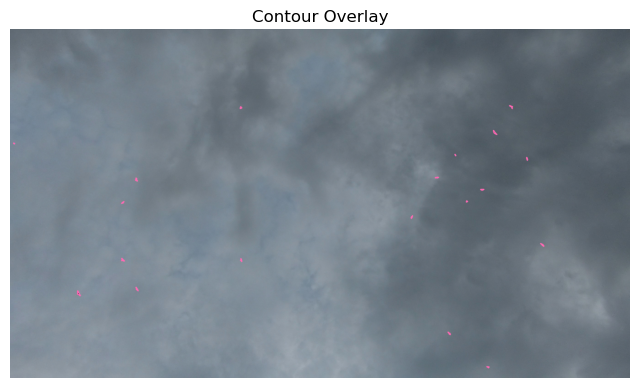

In [15]:
image_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
assert image_bgr is not None, f"Could not read image at {img_path}"

# load the mask in grayscale (single channel) and binarize
mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
assert mask_gray is not None, f"Could not read mask at {mask_path}"
mask_bin = (mask_gray > 0).astype(np.uint8) * 255

# find the outer contours and draw them in pink
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
cv2.drawContours(image_rgb, contours, contourIdx=-1, color=(255, 105, 180), thickness=3)

plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Contour Overlay")
plt.show()

In [17]:
from pathlib import Path
from yolo_seg_utils import masks_to_yolo_seg_lines, write_yolo_seg_file

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
yolo_lines = masks_to_yolo_seg_lines(mask, class_id=0, approx_eps=0.5)

print(f"Found {len(yolo_lines)} objects")
for i, line in enumerate(sorted(yolo_lines), 1):
    print(f"Obj {i}: {line[:120]} ...")
    
label_path = Path(lbl_path) / f"{Path(img_path).stem}.txt"
write_yolo_seg_file(yolo_lines, label_path)




Found 19 objects
Obj 1: 0 0.006657 0.327961 0.002219 0.003289 0.005547 0.326316 0.005547 0.327632 0.006287 0.328947 0.007027 0.328947 0.007396 0 ...
Obj 2: 0 0.110947 0.757237 0.005178 0.015789 0.109098 0.749342 0.108728 0.750658 0.109098 0.756579 0.108358 0.759211 0.109837 0 ...
Obj 3: 0 0.181953 0.497368 0.004438 0.006579 0.183802 0.494079 0.183062 0.494079 0.181953 0.496053 0.181213 0.496053 0.181213 0 ...
Obj 4: 0 0.182322 0.661184 0.005178 0.009211 0.180104 0.656579 0.179734 0.657237 0.180473 0.659211 0.180473 0.661842 0.179734 0 ...
Obj 5: 0 0.203772 0.431579 0.003698 0.009211 0.202663 0.426974 0.203033 0.427632 0.203033 0.430263 0.201923 0.432237 0.201923 0 ...
Obj 6: 0 0.205067 0.745066 0.004068 0.011184 0.203033 0.739474 0.203033 0.742105 0.203772 0.743421 0.203772 0.745395 0.203402 0 ...
Obj 7: 0 0.372596 0.225329 0.003328 0.005921 0.372411 0.222368 0.371672 0.222368 0.370932 0.227632 0.372781 0.226974 0.373891 0 ...
Obj 8: 0 0.372781 0.662171 0.002959 0.009868 0.372041 0.657

In [18]:
from pathlib import Path

# set where you want the label to land; using the image stem keeps things tidy
img_path = Path(img_path)  # make sure you have this defined
default_lbl_dir = Path("/Users/cara/Desktop/BA/YOLO/mask_to_yolo_test/labels")
lbl_dir = Path(locals().get("lbl_path", default_lbl_dir))
if "lbl_path" not in locals():
    print(f"lbl_path was not defined; using default {default_lbl_dir}")

lbl_dir.mkdir(parents=True, exist_ok=True)
label_path = lbl_dir / f"{img_path.stem}.txt"

with label_path.open("w") as fh:
    fh.write("\n".join(yolo_lines) + "\n")  # trailing newline is optional

print(f"Saved {len(yolo_lines)} objects → {label_path}")


NameError: name 'lbl_path' is not defined

In [7]:
yolo_lines

['0 0.077108 0.996711 0.003328 0.005263 0.078772 0.994079 0.078033 0.994079 0.075444 0.999342 0.077663 0.999342 0.078402 0.997368 0.078402 0.995395',
 '0 0.835614 0.979605 0.004068 0.003947 0.833580 0.979605 0.834320 0.981579 0.835059 0.980921 0.837278 0.981579 0.837648 0.980921 0.836169 0.978947 0.835059 0.978947 0.834689 0.977632 0.834320 0.977632',
 '0 0.312500 0.973684 0.004438 0.005263 0.314719 0.971711 0.314349 0.971053 0.313979 0.971053 0.313240 0.972368 0.312500 0.971711 0.311021 0.971711 0.310281 0.974342 0.311391 0.974342 0.312500 0.976316 0.313979 0.973684 0.314719 0.973026',
 '0 0.382212 0.967105 0.007766 0.003947 0.378328 0.965132 0.378328 0.966447 0.380917 0.969079 0.383876 0.969079 0.384246 0.968421 0.385725 0.968421 0.386095 0.967763 0.386095 0.966447 0.382766 0.966447 0.382396 0.965789',
 '0 0.292714 0.906250 0.004808 0.004605 0.295118 0.904605 0.294379 0.903947 0.292899 0.905263 0.292530 0.904605 0.292160 0.905263 0.291790 0.904605 0.290311 0.905263 0.291050 0.906579 